<a href="https://colab.research.google.com/github/STEM-tisch/TensorFlow-Lite/blob/master/2.Transfer%20Learning%20with%20TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 450kB 35.8MB/s 
     |████████████████████████████████| 3.9MB 39.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=727714bbc792159b4089d2adcfd6904e62c86fe181b52827479c1cbcfaf9e304
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Fo

In [0]:
import os
import tensorflow as tf

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [0]:
tfds.disable_progress_bar()

In [0]:
(train_examples, valid_examples, test_examples), info = tfds.load("cats_vs_dogs", 
                                                            split=["train[:80%]", "train[80%:90%]", "train[90%:]"], 
                                                            with_info=True,
                                                            as_supervised=True)

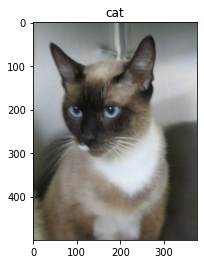

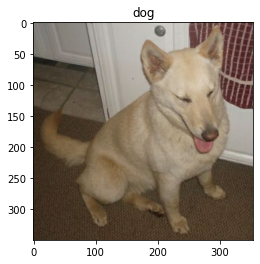

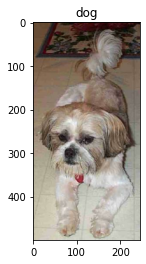

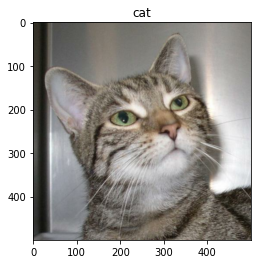

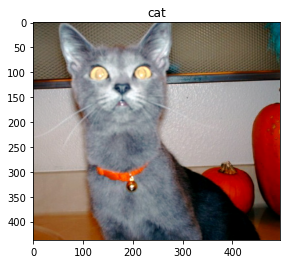

In [37]:
get_label_name = info.features["label"].int2str

for image, label in test_examples.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [0]:
IMAGE_SIZE = 224

def format_img(image, label):

  image = tf.cast (image, tf.float32)

  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255
  return image, label

### Format, Shuffle and Prepare into bacthes

In [0]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32


train_batches = train_examples.shuffle(SHUFFLE_BUFFER_SIZE).map(format_img).batch(BATCH_SIZE)
valid_batches = valid_examples.map(format_img).batch(BATCH_SIZE)
test_batches = test_examples.map(format_img).batch(BATCH_SIZE)

In [40]:
for image_batch, label_batch in test_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

### Build Model from PreTrained Model

We will use MobileNetV2 model for transfer learning

In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top=False, weights="imagenet")

In [42]:
#feature batch 
feature_batch = base_model(image_batch)
print (feature_batch.shape)

(32, 7, 7, 1280)


## Freeze the convolutional feature extraction layer from base model



In [0]:
for layer in base_model.layers:
  layer.trainable = False

In [44]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## Add a classfication Head consisting of a Global Average Pooling and a Dense layer with 1 unit

In [45]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

global_avg_batch = global_avg_layer(feature_batch)
print (global_avg_batch.shape)

(32, 1280)


In [46]:
# Final Prediction Layer

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(global_avg_batch)
print (prediction_batch.shape)

(32, 1)


In [47]:
#Build the model

model = tf.keras.models.Sequential()

model.add(base_model)
model.add(global_avg_layer)
model.add(prediction_layer)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [48]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(lr=0.001), metrics=["accuracy"])

history = model.fit(train_batches, validation_data=valid_batches, epochs=10, verbose=1)

Epoch 1/10
582/582 [==============================] - 62s 106ms/step - loss: 1.1469 - accuracy: 0.8737 - val_loss: 0.9414 - val_accuracy: 0.9140
Epoch 2/10
582/582 [==============================] - 58s 100ms/step - loss: 0.5160 - accuracy: 0.9427 - val_loss: 1.5493 - val_accuracy: 0.8620
Epoch 3/10
582/582 [==============================] - 58s 100ms/step - loss: 0.4564 - accuracy: 0.9509 - val_loss: 0.6800 - val_accuracy: 0.9364
Epoch 4/10
582/582 [==============================] - 58s 99ms/step - loss: 0.4204 - accuracy: 0.9548 - val_loss: 0.4828 - val_accuracy: 0.9557
Epoch 5/10
582/582 [==============================] - 58s 99ms/step - loss: 0.4247 - accuracy: 0.9559 - val_loss: 0.8429 - val_accuracy: 0.9213
Epoch 6/10
582/582 [==============================] - 58s 99ms/step - loss: 0.3850 - accuracy: 0.9601 - val_loss: 0.3931 - val_accuracy: 0.9678
Epoch 7/10
582/582 [==============================] - 58s 99ms/step - loss: 0.4169 - accuracy: 0.9594 - val_loss: 0.6424 - val_accura

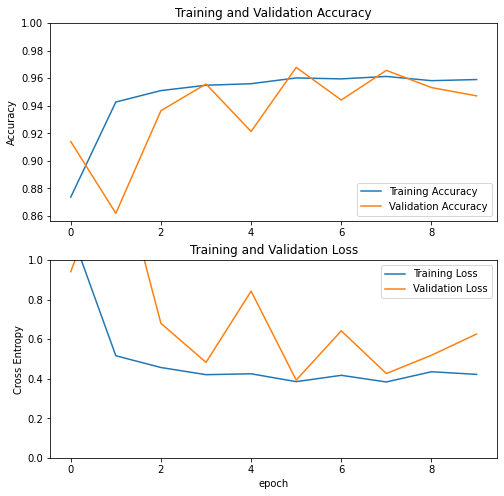

In [49]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
print ("Number of layers in the base_model ", len(base_model.layers))

Number of layers in the base_model  155


In [0]:
freeze_top = 75

for layer in base_model.layers[:freeze_top]:
  layer.trainable = False

  
for layer in base_model.layers[freeze_top:]:
  layer.trainable = True
  

In [51]:
for i, layer in enumerate(base_model.layers):
  print ("Layer: ", i , "Trainable:", layer.trainable)

Layer:  0 Trainable: False
Layer:  1 Trainable: False
Layer:  2 Trainable: False
Layer:  3 Trainable: False
Layer:  4 Trainable: False
Layer:  5 Trainable: False
Layer:  6 Trainable: False
Layer:  7 Trainable: False
Layer:  8 Trainable: False
Layer:  9 Trainable: False
Layer:  10 Trainable: False
Layer:  11 Trainable: False
Layer:  12 Trainable: False
Layer:  13 Trainable: False
Layer:  14 Trainable: False
Layer:  15 Trainable: False
Layer:  16 Trainable: False
Layer:  17 Trainable: False
Layer:  18 Trainable: False
Layer:  19 Trainable: False
Layer:  20 Trainable: False
Layer:  21 Trainable: False
Layer:  22 Trainable: False
Layer:  23 Trainable: False
Layer:  24 Trainable: False
Layer:  25 Trainable: False
Layer:  26 Trainable: False
Layer:  27 Trainable: False
Layer:  28 Trainable: False
Layer:  29 Trainable: False
Layer:  30 Trainable: False
Layer:  31 Trainable: False
Layer:  32 Trainable: False
Layer:  33 Trainable: False
Layer:  34 Trainable: False
Layer:  35 Trainable: False
La

In [52]:
fine_tune_epochs = 10
initial_epochs = 10
total_epochs  =  fine_tune_epochs  + initial_epochs
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(lr=0.0001 / 10 ), metrics=["accuracy"])


fine_tune_history = model.fit(train_batches, validation_data=valid_batches, epochs=total_epochs, initial_epoch=history.epoch[-1], verbose=1)

Epoch 10/20
582/582 [==============================] - 71s 122ms/step - loss: 0.3531 - accuracy: 0.9673 - val_loss: 0.3482 - val_accuracy: 0.9721
Epoch 11/20
582/582 [==============================] - 64s 111ms/step - loss: 0.2702 - accuracy: 0.9740 - val_loss: 0.3764 - val_accuracy: 0.9686
Epoch 12/20
582/582 [==============================] - 64s 111ms/step - loss: 0.2637 - accuracy: 0.9749 - val_loss: 0.3197 - val_accuracy: 0.9721
Epoch 13/20
582/582 [==============================] - 64s 111ms/step - loss: 0.2107 - accuracy: 0.9800 - val_loss: 0.3306 - val_accuracy: 0.9682
Epoch 14/20
582/582 [==============================] - 65s 111ms/step - loss: 0.1799 - accuracy: 0.9834 - val_loss: 0.3214 - val_accuracy: 0.9699
Epoch 15/20
582/582 [==============================] - 64s 110ms/step - loss: 0.1721 - accuracy: 0.9831 - val_loss: 0.2975 - val_accuracy: 0.9716
Epoch 16/20
582/582 [==============================] - 64s 110ms/step - loss: 0.1425 - accuracy: 0.9857 - val_loss: 0.3205 -

In [0]:

acc += fine_tune_history.history['accuracy']
val_acc += fine_tune_history.history['val_accuracy']

loss += fine_tune_history.history['loss']
val_loss += fine_tune_history.history['val_loss']

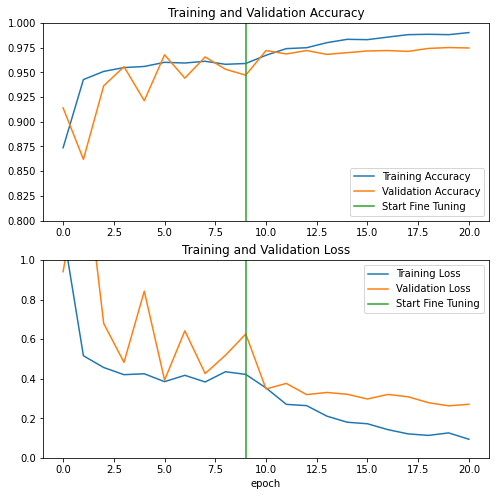

In [54]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### TFLit Model Conversion Steps

In [55]:
CATS_DOGS_SAVED_MODEL = "exp_saved_model"

#Export the model

tf.saved_model.save(model, CATS_DOGS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


In [56]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

2020-04-12 06:23:48.019288: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-12 06:23:48.019433: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-12 06:23:48.019458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/tools/saved_model_cli.

In [0]:
load_model = tf.saved_model.load(CATS_DOGS_SAVED_MODEL)

In [59]:
print(list(load_model.signatures.keys()))
infer = load_model.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'mobilenetv2_1.00_224_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='mobilenetv2_1.00_224_input')})
{'dense_1': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_1')}


### Convert the model using TFLite Converter

In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_DOGS_SAVED_MODEL)

### Post-training quantization
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [0]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

### Post-training integer quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [0]:
def representative_datagen():
  for input_data, _ in test_batches.take(100):
    yield [input_data]

In [0]:
converter.representative_dataset = representative_datagen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float. 

### Full integer quantization

To require the converter to only output integer operations, one can specify:

In [0]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

### Finally convert the model

In [72]:
tflite_model = converter.convert()
tflite_model_file = "tfliet_cvsd_model.tflite"

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

ValueError: ignored